# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

- 모델 설계
전체 데이터를 학습하는 것은 문제가 될 수 있어서 데이터의 건 수를 줄였습니다.


In [ ]:
!pip install transformers datasets evaluate accelerate scikit-learn

[MYCODE] 필요한 모듈을 import 합니다.

- 불필요한 로그 레벨을 조절합니다.

In [53]:
import random
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import logging as log
for handler in log.root.handlers[:]:
    log.root.removeHandler(handler)

log.getLogger("urllib3.connectionpool").setLevel(log.CRITICAL)
log.getLogger('matplotlib').setLevel(log.WARNING)
log.basicConfig(level=log.DEBUG)

## 1. [MYCODE] Dataset 준비
- 데이터 셋을 토큰 처리하기 위한 클래스를 하나 선언합니다.
- load_dataset
- prepocess_function
- get_tokenized
- get_train

In [35]:
class BertBaseCasedAutoTokenizer:

    def __init__(self, model_name: str = "bert-base-cased", max_length=128):
        # 클래스 초기화 시 tokenizer 로드
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.load_dataset # 데이터셋 초기화
        self.max_length = max_length # 토큰 최대 길이

    def load_dataset(self, input_dataset):
        self.load_dataset = input_dataset
        log.debug(f"self dataset = {self.load_dataset}")
        return self.load_dataset

    def preprocess_function(self, data):
        """
        배치 데이터를 처리하는 함수
        """
        return self.tokenizer(
            data['premise'], data['hypothesis'],
            truncation=True,
            max_length=self.max_length,
            padding="max_length"
        )

    def get_tokenized(self):
        """
        데이터셋을 토큰화하여 반환
        """
        log.debug("Tokenizing dataset")
        tokenized_dataset = self.load_dataset.map(self.preprocess_function, batched=True)
        tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids", "label"])
        return tokenized_dataset

    def get_train(self, index):
        return self.load_dataset['train'][index]

### [MYCODE] reduce_dataset을 통해 데이터 건수를 10만건으로 제한했습니다.

In [ ]:
def reduce_dataset(dataset_dict, sample_size=None, sample_ratio=None):
    """
    데이터셋 크기를 줄이는 함수
    Args:
        dataset_dict (DatasetDict): 전체 데이터셋
        sample_size (int): 각 스플릿에서 사용할 최대 샘플 크기
        sample_ratio (float): 각 스플릿에서 사용할 샘플 비율 (0 < sample_ratio <= 1)

    Returns:
        DatasetDict: 크기가 줄어든 데이터셋
    """
    reduced_datasets = {}
    for split, dataset in dataset_dict.items():
        if sample_size:  # 샘플 크기로 제한
            reduced_datasets[split] = dataset.select(range(min(len(dataset), sample_size)))
        elif sample_ratio:  # 샘플 비율로 제한
            reduced_datasets[split] = dataset.train_test_split(test_size=1 - sample_ratio)["train"]
        else:  # 샘플 크기나 비율이 주어지지 않은 경우 원본 유지
            reduced_datasets[split] = dataset

    return DatasetDict(reduced_datasets)

loade_datasets = load_dataset(path="nyu-mll/glue", name="mnli")
loade_datasets = reduce_dataset(loade_datasets, 100000)

###[MYCODE] 데이터 확인

In [10]:
bbcatokenizer  = BertBaseCasedAutoTokenizer()
bbcatokenizer.load_dataset(loade_datasets)

train_dataset = bbcatokenizer.get_train(slice(0,1))
log.debug(f"train = {train_dataset}")
log.debug(f"train = {train_dataset['premise']}")
log.debug(f"train = {train_dataset['hypothesis']}")
log.debug(f"train = {train_dataset['label']}")

tokenizerers = bbcatokenizer.get_tokenized()
log.debug(f"train = {tokenizerers['train'][:2]}")

DEBUG:filelock:Attempting to acquire lock 133067519633216 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ba5de7675473164e07f3b3531748c9a6f113a2c.lock
DEBUG:filelock:Lock 133067519633216 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ba5de7675473164e07f3b3531748c9a6f113a2c.lock


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 133067519633216 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ba5de7675473164e07f3b3531748c9a6f113a2c.lock
DEBUG:filelock:Lock 133067519633216 released on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ba5de7675473164e07f3b3531748c9a6f113a2c.lock
DEBUG:filelock:Attempting to acquire lock 133067519632832 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/107460496b431545e4f921afb3fd5486fd2ae79d.lock
DEBUG:filelock:Lock 133067519632832 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/107460496b431545e4f921afb3fd5486fd2ae79d.lock


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 133067519632832 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/107460496b431545e4f921afb3fd5486fd2ae79d.lock
DEBUG:filelock:Lock 133067519632832 released on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/107460496b431545e4f921afb3fd5486fd2ae79d.lock
DEBUG:filelock:Attempting to acquire lock 133067545364176 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ea941cc79a6f3d7985ca6991ef4f67dad62af04.lock
DEBUG:filelock:Lock 133067545364176 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ea941cc79a6f3d7985ca6991ef4f67dad62af04.lock


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 133067545364176 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ea941cc79a6f3d7985ca6991ef4f67dad62af04.lock
DEBUG:filelock:Lock 133067545364176 released on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/2ea941cc79a6f3d7985ca6991ef4f67dad62af04.lock
DEBUG:filelock:Attempting to acquire lock 133067545368496 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/1ab2a0d23e5a032b6dcd6a3d0976c2af4d2c27f8.lock
DEBUG:filelock:Lock 133067545368496 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/1ab2a0d23e5a032b6dcd6a3d0976c2af4d2c27f8.lock


tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 133067545368496 on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/1ab2a0d23e5a032b6dcd6a3d0976c2af4d2c27f8.lock
DEBUG:filelock:Lock 133067545368496 released on /root/.cache/huggingface/hub/.locks/models--bert-base-cased/1ab2a0d23e5a032b6dcd6a3d0976c2af4d2c27f8.lock
DEBUG:root:self dataset = DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 100000
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
DEBUG:root:train = {'premise

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmpfkzgiuhk


Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmpvc9ywx7u


Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmp91nq0l3o


Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmpgm27j35f


Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmpskzuy0x4
DEBUG:root:train = {'label': tensor([1, 0]), 'input_ids': tensor([[  101, 28103, 14795,  7081, 10458, 25004,  1144,  1160,  3501, 10082,
           118,  3317,  1105, 14534,   119,   102, 22249,  1105, 14534,  1132,
          1184,  1294,  7081, 10458, 25004,  1250,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

In [ ]:
bbcatokenizer.tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

### [MYCODE] train 전체 데이터의 70% 를 학습데이터로 활용
- 30% 검증데이터로 사용

In [48]:
mnli_split = tokenizerers['train'].train_test_split(test_size=0.3)
mnli_train, mnli_val = mnli_split['train'], mnli_split['test']
mnli_valid_matched = tokenizerers['validation_matched']

log.debug(f"imdb_train = {mnli_train}")
log.debug(f"imdb_val = {mnli_val}")
log.debug(f"tokenizerers= {mnli_valid_matched}")

DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmp9of1_ui3
DEBUG:fsspec.local:open file: /root/.cache/huggingface/datasets/nyu-mll___glue/mnli/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c/tmp3wbbozhi
DEBUG:root:imdb_train = Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 70000
})
DEBUG:root:imdb_val = Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30000
})
DEBUG:root:tokenizerers= Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9815
})


### [MYCODE] 레이블이 균등한지 확인

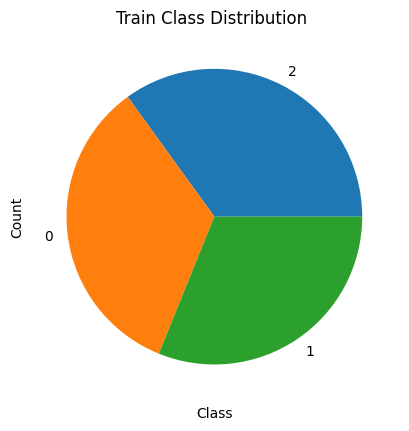

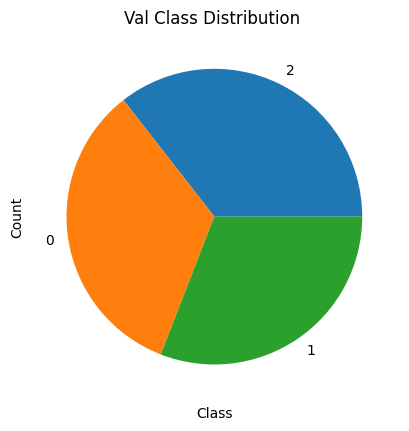

In [ ]:
# 레이블 분포 확인
train_label_counts = pd.Series(mnli_train['label']).value_counts()
val_label_counts = pd.Series(mnli_val['label']).value_counts()
# 클래스 비율 시각화
train_label_counts.plot(kind="pie")
plt.title("Train Class Distribution ")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

val_label_counts.plot(kind="pie")
plt.title("Val Class Distribution ")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
import torch

train_label, train_counts = torch.unique(mnli_train['label'], return_counts=True)
val_label, val_counts = torch.unique(mnli_val['label'], return_counts=True)

# 출력

log.debug(f"train_label_counter: {train_counts}", )
log.debug(f"val_label_counter: {val_counts}", )                # 각 고유 값의 개수

DEBUG:root:train_label_counter: tensor([23736, 21786, 24478])
DEBUG:root:val_label_counter: tensor([10067,  9271, 10662])


## 2. [MYCODE] 모델 선언
- 레이블 분류를 위해서 마지막 레이블 수는 3개로 정의
- 모든 파라미터중 :4번째 레이어까지 파라미터 고정 처리

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=3
)

# DistilBERT의 모든 파라미터 고정
for param in model.distilbert.transformer.layer[:4].parameters():
    param.requires_grad = False  # 마지막 두 레이어만 학습
log.debug(model)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DEBUG:root:DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_li

distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbert.t

In [55]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
import wandb
wandb.init(project="my-mnli-project", name="experiment_name")

## [MYCODE] 모델 학습
- 배치사이즈 64
- 에폭마다 모델을 저장
- 모델 정보를 WanDB로 로그전송
- 학습률 2e-5

In [ ]:
# TrainingArguments 설정
# 매 Epoch마다 검증
# 로그 디렉토리
training_args = TrainingArguments(
    output_dir="./results_2layer",
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,   # 매 100 스텝마다 훈련 손실 기록 (수정)
    learning_rate=2e-5,  # 학습률 (조정 가능)
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,  # Epoch 증가 (수정 가능)
    weight_decay=0.01,
    load_best_model_at_end=True,       # 최적 모델 로드 (추가)
    save_strategy="epoch",  # 매 Epoch마다 모델 저장
    metric_for_best_model="eval_loss", # 최적 모델 선택 기준
    report_to=["wandb"],  # WandB로 로그 전송
)

# 2번 이상 증가시 중단
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Trainer 초기화
trainer = Trainer(
    model=model,  # 모델 전달 (수정)
    args=training_args,  # 학습 인자 전달 (수정)
    train_dataset=mnli_train,  # 학습 데이터셋 전달 (수정)
    eval_dataset=mnli_val,  # 검증 데이터셋 전달 (수정)
    processing_class=bbcatokenizer.tokenizer,  # 올바른 토크나이저 전달 (수정)
    compute_metrics=compute_metrics,  # 평가 함수 추가 (수정)
    callbacks=[early_stopping]
)

# 학습 시작
trainer.train()  # 학습 실행 (수정)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.988000,0.963502,0.530133,0.526343
2,0.933700,0.934465,0.553333,0.552717
3,0.890600,0.921636,0.567900,0.564553
4,0.856800,0.932151,0.569967,0.570438


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.988000,0.963502,0.530133,0.526343
2,0.933700,0.934465,0.553333,0.552717
3,0.890600,0.921636,0.567900,0.564553
4,0.856800,0.932151,0.569967,0.570438
5,0.829500,0.915646,0.576833,0.577477
6,0.778900,0.924299,0.581733,0.582146
7,0.758100,0.926148,0.583067,0.582627


TrainOutput(global_step=7658, training_loss=0.8739630812980949, metrics={'train_runtime': 4682.9753, 'train_samples_per_second': 149.478, 'train_steps_per_second': 2.336, 'total_flos': 1.622754572544e+16, 'train_loss': 0.8739630812980949, 'epoch': 7.0})

### [MYCODE] valid_matched 데이터 검증

In [ ]:
trainer.evaluate(mnli_valid_matched)

{'eval_loss': 0.9330617189407349,
 'eval_accuracy': 0.5714722363728987,
 'eval_f1': 0.5720398394262336,
 'eval_runtime': 35.1805,
 'eval_samples_per_second': 278.989,
 'eval_steps_per_second': 4.377,
 'epoch': 7.0}

In [ ]:
# 예측 결과
predictions = trainer.predict(mnli_val)

# 로짓에서 argmax로 클래스 예측
predicted_labels = predictions.predictions.argmax(axis=-1)

# 정답 라벨
true_labels = predictions.label_ids

# Confusion Matrix 생성
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### [MYCODE] 모델 Plot 처리하기

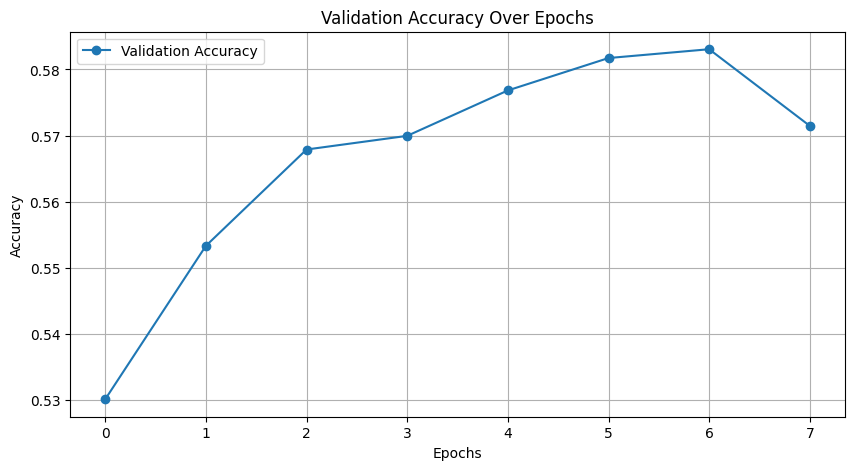

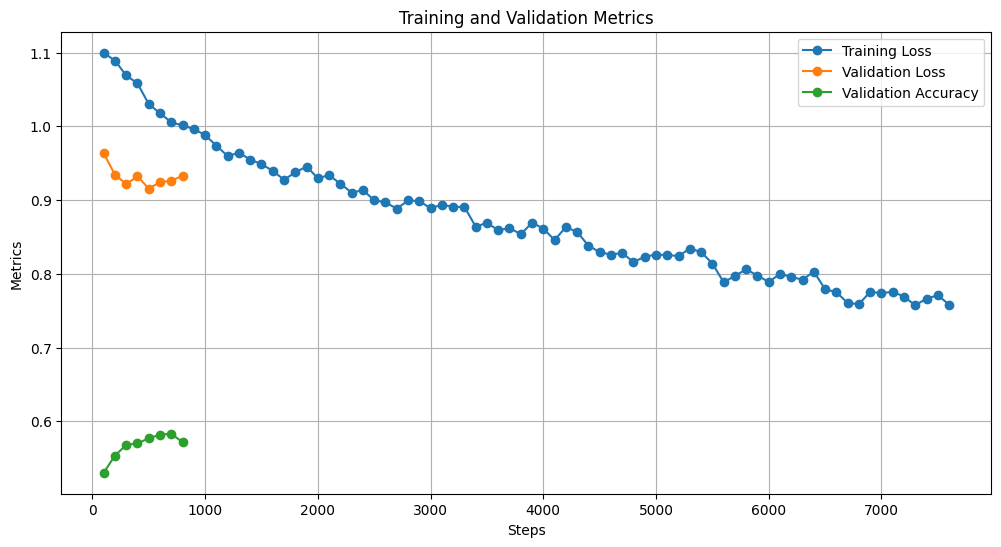

In [ ]:
# Trainer 실행 후 로그 데이터 가져오기
log_history = trainer.state.log_history

# 학습 손실과 검증 손실 데이터 추출
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
steps = [entry["step"] for entry in log_history if "loss" in entry]

# 정확도 데이터 추출
eval_accuracies = [entry["eval_accuracy"] for entry in log_history if "eval_accuracy" in entry]

import matplotlib.pyplot as plt

# 정확도 플롯
plt.figure(figsize=(10, 5))
plt.plot(range(len(eval_accuracies)), eval_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# 손실과 정확도 플롯
plt.figure(figsize=(12, 6))

# Training Loss
plt.plot(steps, train_losses, label="Training Loss", marker='o')

# Validation Loss
plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss", marker='o')

# Validation Accuracy
plt.plot(steps[:len(eval_accuracies)], eval_accuracies, label="Validation Accuracy", marker='o')

plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import os
os._exit(0)

## [MYCODE] 모델 얼리스탑한 상황에서 정확도와 val_loss 어떻게 줄일것인가? (아래 내용은 새롭게 모델 학습을 시도했습니다)
- 토큰 최대길이를 128로 설정했으나 실제 최대 길이 확인.    
실제로 길이를 확인해보니 350 토큰 길이를 갖는 것으로 보여져 350으로 변경했습니다.
- 변경을 통해 정확도 66, val_loss 가 78 로 떨어지는 것을 확인할 수 있었습니다.


### [FEEDBACK]
- 좀 더 정확도를 높이기 위해서 MASK 기법을 이용하면 좋을지 고민이 되네요


In [31]:
# 토큰 길이 계산 함수
def calculate_token_lengths(dataset, tokenizer):
    # premise와 hypothesis를 합쳐 하나의 문장으로 만든 후 길이 계산
    token_lengths = [
        len(tokenizer.encode(f"{row['premise']} {row['hypothesis']}",
                             truncation=False, add_special_tokens=True))
        for row in dataset
    ]
    return token_lengths

# 각 데이터셋에 대해 최대 토큰 길이 계산
max_token_lengths = {}
for split in loade_datasets.keys():  # 'train', 'validation_matched', ...
    dataset = loade_datasets[split]
    token_lengths = calculate_token_lengths(dataset, auto_tokenizer)
    max_token_lengths[split] = max(token_lengths)

print(max_token_lengths)

{'train': 341, 'validation_matched': 238, 'validation_mismatched': 224, 'test_matched': 250, 'test_mismatched': 269}


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/week4/basic_transformer/checkpoint-7658", num_labels=3
)

# DistilBERT의 모든 파라미터 고정
for param in model.distilbert.transformer.layer[:4].parameters():
    param.requires_grad = False  # 마지막 두 레이어만 학습
log.debug(model)

DEBUG:root:DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inpl

In [50]:
bbcatokenizer2 = BertBaseCasedAutoTokenizer(max_length=350)
bbcatokenizer2.load_dataset(loade_datasets)

DEBUG:root:self dataset = DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 100000
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 100000
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [59]:
# TrainingArguments 설정
# 매 Epoch마다 검증
# 로그 디렉토리
training_args = TrainingArguments(
    output_dir="./results_2layer",
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,   # 매 100 스텝마다 훈련 손실 기록 (수정)
    learning_rate=2e-5,  # 학습률 (조정 가능)
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,  # Epoch 증가 (수정 가능)
    weight_decay=0.01,
    load_best_model_at_end=True,       # 최적 모델 로드 (추가)
    save_strategy="epoch",  # 매 Epoch마다 모델 저장
    metric_for_best_model="eval_loss", # 최적 모델 선택 기준
)

# 2번 이상 증가시 중단
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Trainer 초기화
trainer = Trainer(
    model=model,  # 모델 전달 (수정)
    args=training_args,  # 학습 인자 전달 (수정)
    train_dataset=mnli_train,  # 학습 데이터셋 전달 (수정)
    eval_dataset=mnli_val,  # 검증 데이터셋 전달 (수정)
    processing_class=bbcatokenizer2.tokenizer,  # 올바른 토크나이저 전달 (수정)
    compute_metrics=compute_metrics,  # 평가 함수 추가 (수정)
    callbacks=[early_stopping]
)

# 학습 시작
trainer.train()  # 학습 실행 (수정)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.672700,0.777739,0.664900,0.664980
2,0.720000,0.776209,0.662800,0.661800
3,0.675200,0.782838,0.663000,0.662471
4,0.626500,0.792713,0.662833,0.662376


TrainOutput(global_step=4376, training_loss=0.6747311613023608, metrics={'train_runtime': 2741.067, 'train_samples_per_second': 127.688, 'train_steps_per_second': 1.996, 'total_flos': 9272883271680000.0, 'train_loss': 0.6747311613023608, 'epoch': 4.0})

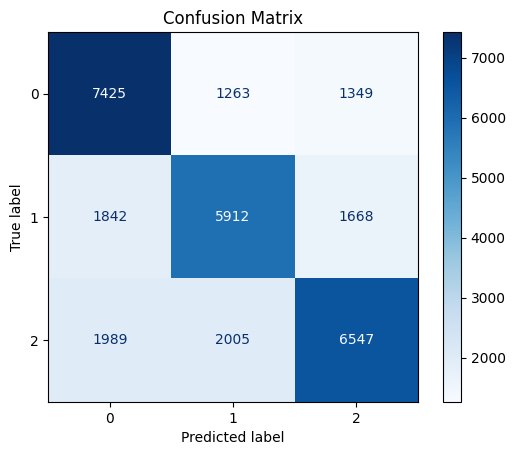

In [60]:
# 예측 결과
predictions = trainer.predict(mnli_val)

# 로짓에서 argmax로 클래스 예측
predicted_labels = predictions.predictions.argmax(axis=-1)

# 정답 라벨
true_labels = predictions.label_ids

# Confusion Matrix 생성
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()